In [1]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

import math

2.0.1
2.7.0+cpu


In [2]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

In [3]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden):
        super().__init__()
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
        
        
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x
        

0.4596605598926544
[[ 0.  0.  1.]
 [ 0.  0.  0.]
 [ 0. -1.  0.]]
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 1., 0.]],

         [[1., 1., 0.],
          [1., 1., 1.],
          [1., 0., 1.]],

         [[0., 0., 1.],
          [0., 0., 0.],
          [0., 0., 0.]]]])


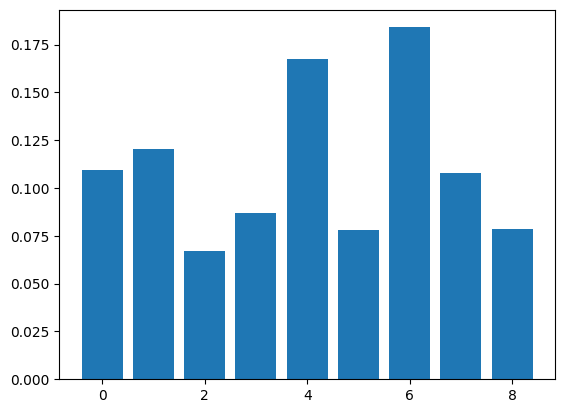

In [4]:
import matplotlib.pyplot as plt

tictactoe = TicTacToe()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, 1)
state = tictactoe.get_next_state(state, 7, -1)

encoded_state = tictactoe.get_encoded_state(state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(tictactoe, 4, 64)

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

print(state)
print(tensor_state)

plt.bar(range(tictactoe.action_size), policy)
plt.show()

In [5]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = 0
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
                
        return child
            
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                
                value = value.item()
                
                node.expand(policy)
                
            node.backpropagate(value)    
            
            
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

In [6]:
tictactoe = TicTacToe()
player = 1

args = {
    'C': 2,
    'num_searches': 1000
}

model = ResNet(tictactoe, 4, 64)
model.eval()

mcts = MCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()


while True:
    print(state)
    
    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid_moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue
            
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = tictactoe.get_next_state(state, action, player)
    
    value, is_terminal = tictactoe.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break
        
    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8]


1: 0


[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  0.]]
valid_moves [1, 2, 3, 5, 6, 7, 8]


1: 1


[[ 1.  1.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  0.]]
[[ 1.  1. -1.]
 [ 0. -1.  0.]
 [ 0.  0.  0.]]
valid_moves [3, 5, 6, 7, 8]


1: 8


[[ 1.  1. -1.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
[[ 1.  1. -1.]
 [ 0. -1.  0.]
 [-1.  0.  1.]]
-1 won
